In [1]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import findspark
findspark.init()
import os
os.environ['JAVA_HOME'] = 'D:\\Java\\jdk1.8.0_202\\'

In [2]:
sc = SparkContext ()
spark = SparkSession\
    .builder \
    .appName("HW_SparkSQL") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
path = '\\Users\\kimil\\OneDrive\\Desktop\\MUIC_work\\BigData\\BigData\\Data\\'

In [4]:
lines = sc.textFile(path+"*.txt") 
print(lines)

\Users\kimil\OneDrive\Desktop\MUIC_work\BigData\BigData\Data\*.txt MapPartitionsRDD[1] at textFile at NativeMethodAccessorImpl.java:0


In [5]:
lines.count()

252722

In [6]:
words = lines.flatMap(lambda line : line.split(" "))
tuples = words.map(lambda word : (word, 1)) 
import re
def rem(x):
    return re.sub('[^a-zA-Z0-9 \n.]', '', x)
tuples2 = tuples.map(lambda x:(rem(x[0]),x[1]))
counts = tuples2.reduceByKey(lambda a, b: (a + b))
sorts=counts.sortByKey(False)

In [7]:
print(sorts.glom().collect())
header =['word', 'count']
dfFromRDD=sorts.toDF(header)
dfFromRDD.printSchema()
dfFromRDD.show()

[[('zwaggerd', 2), ('zounds', 4), ('zone', 2), ('zodiacs', 2), ('zodiac', 2), ('zo', 2), ('zir.', 2), ('zir', 2), ('zip', 2), ('zigzag', 1), ('zephyrs', 2), ('zenith', 2), ('zed', 2), ('zeals', 2), ('zealous', 12), ('zeal.', 8), ('zeal', 56), ('zany', 2), ('zanies.', 2), ('youyou', 2), ('youwondrous', 2), ('youwell', 2), ('youve', 5), ('youtli', 2), ('youths', 18), ('youthful', 62), ('youthat', 2), ('youth.', 50), ('youth', 496), ('youst', 2), ('yoursnot', 2), ('yourselves.', 30), ('yourselves', 116), ('yourself.', 86), ('yourself', 460), ('yours.', 129), ('yours', 367), ('yourlogin', 2), ('youre', 45), ('your', 12082), ('youpray', 2), ('youoften', 2), ('younker', 6), ('youngst', 2), ('youngs', 2), ('youngly', 4), ('younglings', 2), ('youngeyd', 2), ('youngest', 46), ('younger.', 4), ('younger', 56), ('young.', 18), ('young', 789), ('youll', 208), ('yould', 2), ('youhe', 2), ('youfl', 2), ('youd', 30), ('youare', 1), ('youall', 1), ('youThat', 2), ('youR', 2), ('youI', 2), ('you.', 164

In [8]:
from pyspark.sql.functions import udf
def LowerCase(str):
  return str.lower()
lowerCaseUDF=udf(lambda z: LowerCase(z))

In [9]:
Lowered_df = dfFromRDD.withColumn("word",lowerCaseUDF("word"))

In [10]:
Lowered_df.createOrReplaceTempView("words")
joined_df = spark.sql("""
    SELECT word, SUM(count) as total_count
    FROM words
    GROUP BY word
    ORDER BY total_count DESC
""")

In [11]:
filtered_df = joined_df.filter(joined_df["total_count"] > 10)

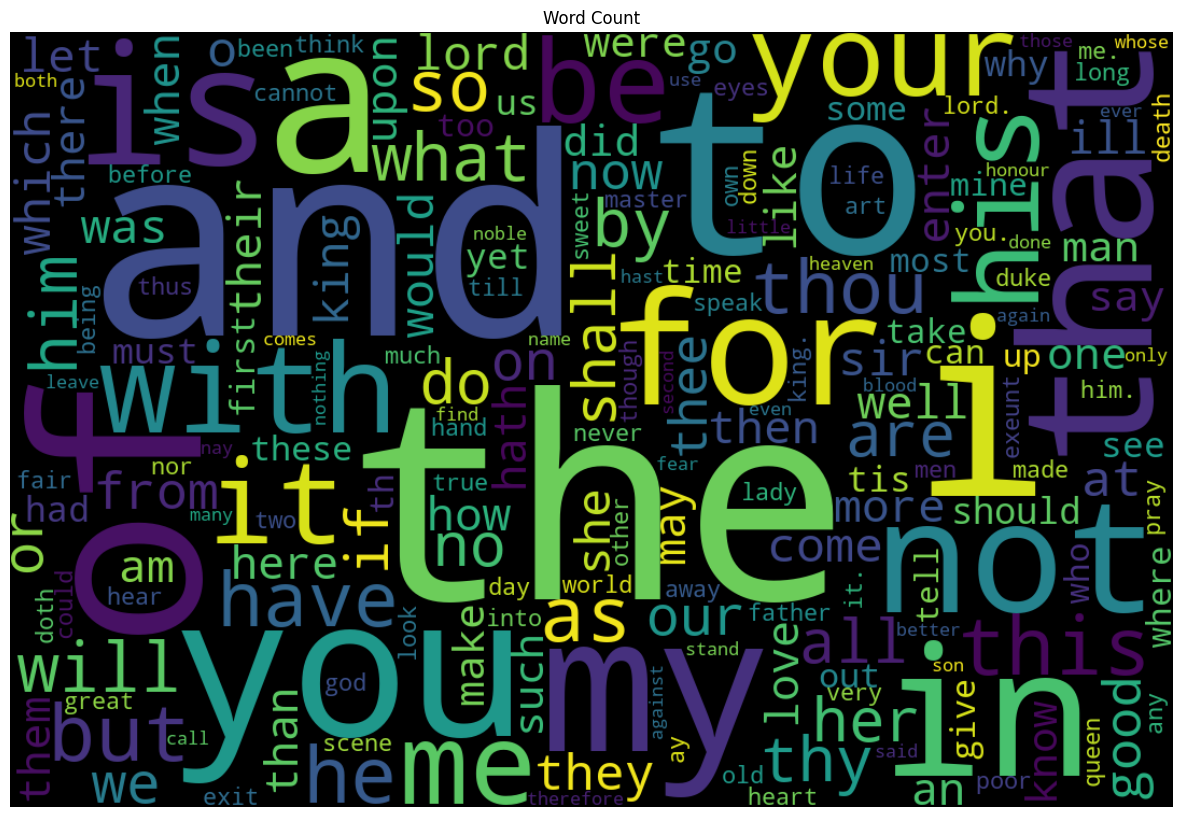

In [23]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

filtered_pd = filtered_df.toPandas()
# Create a dictionary of words and their frequencies
word_freq = {row['word']: row['total_count'] for index, row in filtered_pd.iterrows()}

# Generate word cloud
wordcloud = WordCloud(width=1080, height=720, background_color='black').generate_from_frequencies(word_freq)

# Plot word cloud
plt.figure(figsize=(15, 11))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Remove axis
plt.title('Word Count')
plt.show()

In [58]:
path = '\\Users\\kimil\\OneDrive\\Desktop\\MUIC_work\\BigData\\BigData\\SparkSQL\\SparkSQL_WordCount_Out'
filtered_df.write.mode("overwrite").option("header", "true").csv(path)

In [26]:
sc.stop()